In [15]:
import uavgeo as ug
import geopandas as gpd
import rioxarray
import numpy as np
import ultralytics
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

# pix2pix result analysis

Repeated for canyelles + btg
1. Data loading (p2p, p2phd, real)
2. flattening data
3. plotting hexbins + 1:1 line

In [27]:
# load data btg2022

ndvi_p2phd = rxr.open_rasterio("../data/orthos/reconstructed/ndvi_p2p_hd_2022.tif",mode = "w")
ndvi_p2p = rxr.open_rasterio("../data/orthos/reconstructed/ndvi_p2p_v2_2022.tif",mode = "w")
ndvi_test = rxr.open_rasterio("../data/orthos/ndvi_2022_test.tif",mode = "w")
rgb = rxr.open_rasterio("../data/orthos/rgb_2022.tif", mode ="w")

In [28]:

roi = gpd.read_file("../data/bbr/btg2022/roi/RoI.shp")

In [29]:
#clip all to the same extent
ndvi_test = ndvi_test.rio.clip(roi.geometry)
ndvi_p2phd = ndvi_p2phd.rio.clip(roi.geometry)
ndvi_p2p = ndvi_p2p.rio.clip(roi.geometry)
rgb = rgb.rio.clip(roi.geometry)

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [30]:
#reproject match p2phd to the other two
ndvi_p2phd = ndvi_p2phd.rio.reproject_match(ndvi_test).sel(band=[1])
ndvi_p2p = ndvi_p2p.rio.reproject_match(ndvi_test).sel(band=[1])
rgb = rgb.rio.reproject_match(ndvi_test)

In [31]:
# add GLI
gli = ug.compute.calc_gli(bandstack = rgb, red_id=1, green_id=2,blue_id=3, rescale =False)
# add GLI
rgbvi = ug.compute.calc_rgbvi(bandstack = rgb, red_id=1, green_id=2,blue_id=3, rescale =False)

In [32]:
from rasterio.enums import Resampling

upscale_factor =0.1
new_width = ndvi_test.rio.width * upscale_factor
new_height = ndvi_test.rio.height * upscale_factor

rgb = rxr.open_rasterio("../data/orthos/rgb_2022.tif", mode ="w")

rgb_down = rgb.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)

ndvi_test_down =ndvi_test.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
)
ndvi_p2p_down =ndvi_p2p.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
)
ndvi_p2phd_down =ndvi_p2phd.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
)
gli_down = gli.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
)
rgbvi_down = rgbvi.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
    
)

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


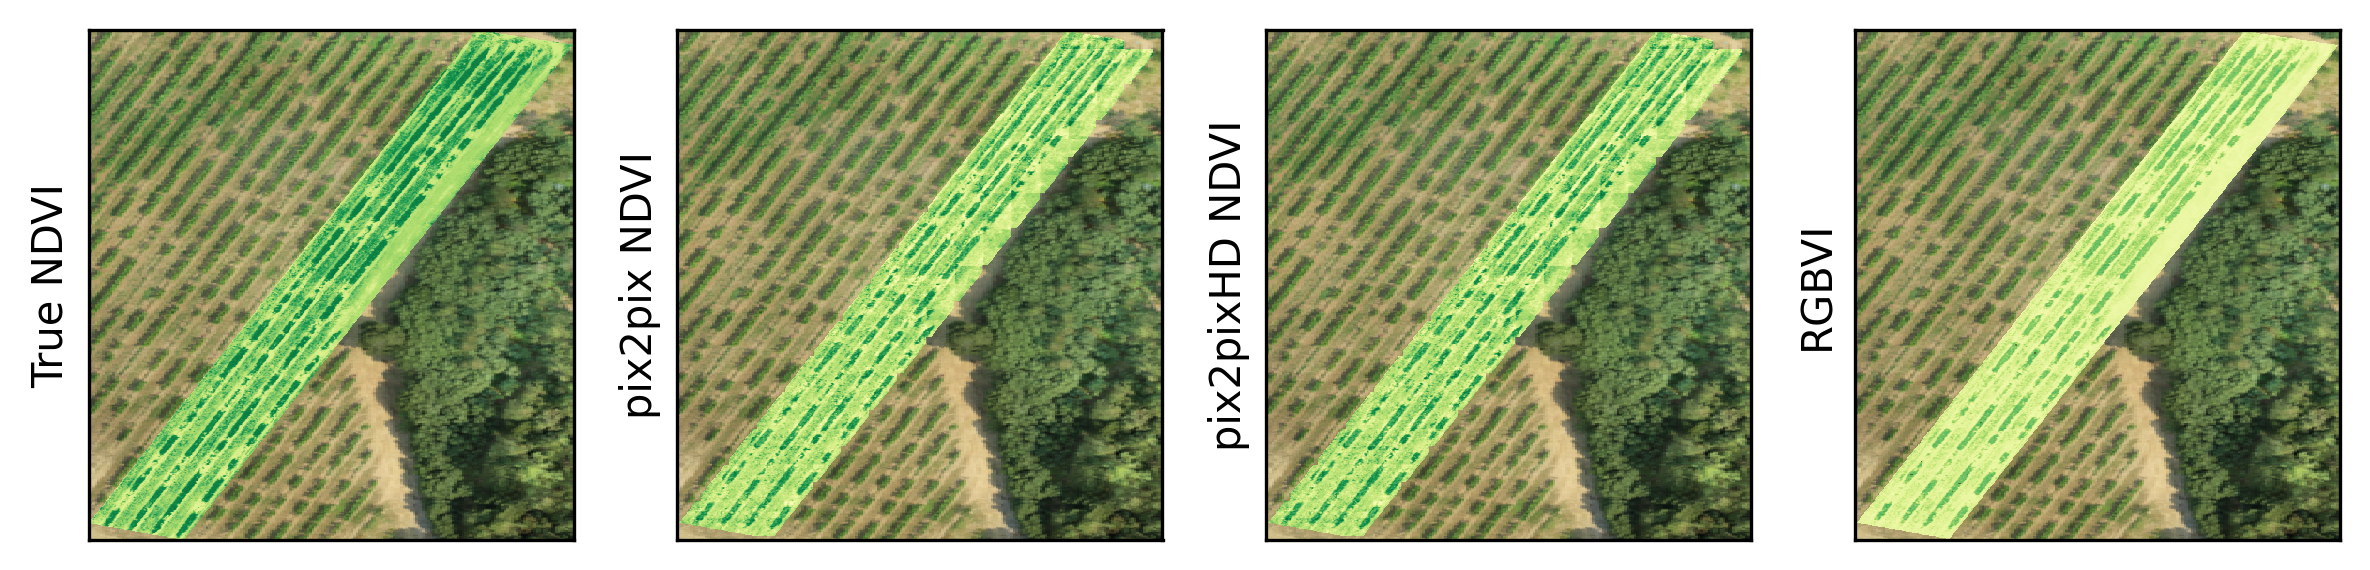

In [33]:

fig,ax = plt.subplots(figsize=(8,2),nrows =1, ncols = 4,dpi=300)

xmin, ymin, xmax, ymax = ndvi_test.rio.bounds()

rgb_down.plot.imshow(ax=ax[0], add_colorbar=False)
ndvi_test_down.plot(ax=ax[0],cmap = "RdYlGn", vmin =-1, vmax =1, add_colorbar=False)
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("True NDVI")
ax[0].set_xlim((xmin,xmax))
ax[0].set_ylim((ymin, ymax))

rgb_down.plot.imshow(ax=ax[1], add_colorbar=False)
ndvi_p2p_down.plot(ax=ax[1], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("pix2pix NDVI")
ax[2].set_xlim((xmin,xmax))
ax[2].set_ylim((ymin, ymax))

rgb_down.plot.imshow(ax=ax[2], add_colorbar=False)
ndvi_p2p_down.plot(ax=ax[2], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("pix2pixHD NDVI")
ax[2].set_xlim((xmin,xmax))
ax[2].set_ylim((ymin, ymax))

rgb_down.plot.imshow(ax=ax[3], add_colorbar=False)
rgbvi_down.plot(ax=ax[3], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[3].set_title("")
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_xlabel("")
ax[3].set_ylabel("RGBVI")
ax[3].set_xlim((xmin,xmax))
ax[3].set_ylim((ymin, ymax))


plt.tight_layout()
plt.savefig("figures/btg2022_ndvi_rgbvi.png")
plt.show()

In [34]:
# FOR CORRELATION CHECKS:
#flatten the ndvi arrays
ndvi_p2phd_flat = ndvi_p2phd.values.flatten()
ndvi_p2p_flat = ndvi_p2p.values.flatten()
ndvi_test_flat = ndvi_test.values.flatten()
rgbvi_flat = rgbvi.values.flatten()

In [35]:
len(rgbvi_flat)

44125950

In [36]:
df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2p":ndvi_p2p_flat,"ndvi_p2phd":ndvi_p2phd_flat, "rgbvi":rgbvi_flat})
df = df.dropna(axis=0)


C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4921: RuntimeWarning: invalid value encountered in cast
  ix1 = np.round(ix).astype(int)
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4922: RuntimeWarning: invalid value encountered in cast
  iy1 = np.round(iy).astype(int)
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4923: RuntimeWarning: invalid value encountered in cast
  ix2 = np.floor(ix).astype(int)
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4924: RuntimeWarning: invalid value encountered in cast
  iy2 = np.floor(iy).astype(int)
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4921: RuntimeWarning: invalid value encountered in cast
  ix1 = np.round(ix).astype(int)
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4922: RuntimeWarning: invalid value encountered in cast
  iy1 = np.round(iy).asty

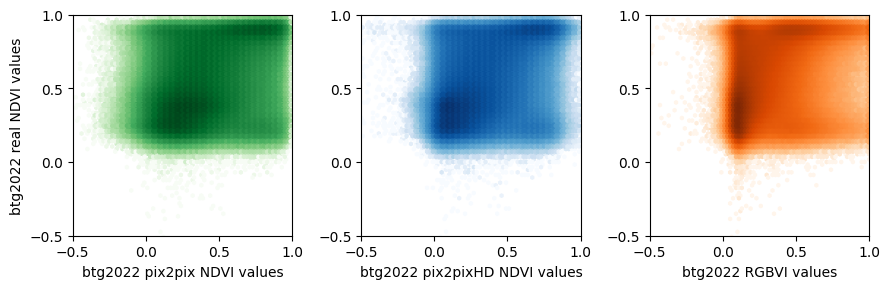

In [41]:
fig, ax = plt.subplots(figsize=(9,3), ncols =3)

#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[0],x = "ndvi_p2p", y = "ndvi_true",extent = (-1,1,-1,1), gridsize=100,cmap = 'Greens', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[0].set_xlim(-0.5,1)
ax[0].set_ylim(-0.5,1)
ax[0].set_xticks([-0.5, 0, 0.5, 1])
ax[0].set_yticks([-0.5, 0, 0.5, 1])
ax[0].set_xlabel('btg2022 pix2pix NDVI values')
ax[0].set_ylabel('btg2022 real NDVI values')

#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[1],x = "ndvi_p2phd", y = "ndvi_true",extent = (-1,1,-1,1), gridsize=100,cmap = 'Blues', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[1].set_xlim(-0.5,1)
ax[1].set_ylim(-0.5,1)
ax[1].set_xticks([-0.5, 0, 0.5, 1])
ax[1].set_yticks([-0.5, 0, 0.5, 1])
ax[1].set_xlabel('btg2022 pix2pixHD NDVI values')
ax[1].set_ylabel('')

df.plot.hexbin(ax=ax[2],x = "rgbvi", y = "ndvi_true",extent = (-1,1,-1,1), gridsize=100,cmap = 'Oranges', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[2].set_xlim(-0.5,1)
ax[2].set_ylim(-0.5,1)
ax[2].set_xticks([-0.5, 0, 0.5, 1])
ax[2].set_yticks([-0.5, 0, 0.5, 1])
ax[2].set_xlabel('btg2022 RGBVI values')
ax[2].set_ylabel('')

plt.tight_layout()
plt.savefig("figures/btg_hexbin_true_vs_p2p_p2phd_rgbvi.png", dpi =300)
plt.show()

In [42]:
from sklearn.metrics import r2_score, mean_squared_error

df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2p":ndvi_p2p_flat})
df = df.dropna(axis=0)

df = df.loc[(df["ndvi_p2p"]>-1) & (df["ndvi_p2p"]<1)].reset_index()
df = df.loc[(df["ndvi_true"]>-1) & (df["ndvi_true"]<1)].reset_index()

x= df["ndvi_p2p"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)

print("R-squared:", "{:.2f}".format(r2))
print("Mean Squared Error:", "{:.2f}".format(mse))
print("Root Mean Squared Error:", "{:.2f}".format(rmse))

R-squared: -0.60
Mean Squared Error: 0.08
Root Mean Squared Error: 0.28


In [43]:
from sklearn.metrics import r2_score, mean_squared_error
df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2phd":ndvi_p2phd_flat})
df = df.dropna(axis=0)
df = df.loc[(df["ndvi_p2phd"]>-1) & (df["ndvi_p2phd"]<1)].reset_index()
df = df.loc[(df["ndvi_true"]>-1) & (df["ndvi_true"]<1)].reset_index()


x= df["ndvi_p2phd"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)
print("R-squared:", "{:.2f}".format(r2))
print("Mean Squared Error:", "{:.2f}".format(mse))
print("Root Mean Squared Error:", "{:.2f}".format(rmse))

R-squared: -1.13
Mean Squared Error: 0.10
Root Mean Squared Error: 0.31


In [44]:
from sklearn.metrics import r2_score, mean_squared_error
df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "rgbvi":rgbvi_flat})
df = df.dropna(axis=0)
df = df.loc[(df["rgbvi"]>-1) & (df["rgbvi"]<1)].reset_index()
df = df.loc[(df["ndvi_true"]>-1) & (df["ndvi_true"]<1)].reset_index()


x= df["rgbvi"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)
print("RGBVI R-squared:", "{:.2f}".format(r2))
print("RGBVI Mean Squared Error:", "{:.2f}".format(mse))
print("RGBVI Root Mean Squared Error:", "{:.2f}".format(rmse))

R-squared: -3.28
Mean Squared Error: 0.13
Root Mean Squared Error: 0.36


## 2. rinse repeat for canyelles

In [46]:
# load data canyelles 2023

ndvi_p2phd = rxr.open_rasterio("../data/orthos/reconstructed/canyelles_ndvi_p2p_hd.tif",mode = "w").sel(band=[1])
ndvi_p2p = rxr.open_rasterio("../data/orthos/reconstructed/canyelles_ndvi_p2p.tif",mode = "w").sel(band=[1])
ndvi_test = rxr.open_rasterio("../data/orthos/reconstructed/canyelles_ndvi_real.tif",mode = "w").sel(band=[1])
rgb = rxr.open_rasterio("../data/canyelles/orthos/rgb_230609.tif", mode= "w")

In [47]:
ndvi_test = ndvi_test.rio.reproject("EPSG:32631")
ndvi_p2p = ndvi_p2p.rio.reproject("EPSG:32631")
ndvi_p2phd = ndvi_p2phd.rio.reproject("EPSG:32631")
rgb = rgb.rio.reproject("EPSG:32631")

In [48]:
ndvi_p2phd = ndvi_p2phd.rio.reproject_match(ndvi_test)
ndvi_p2p = ndvi_p2p.rio.reproject_match(ndvi_test)
rgb = rgb.rio.reproject_match(ndvi_test)

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [49]:
# Canyelles 2023 cut out assessment rows:
p = gpd.read_file("../data/canyelles/shapes/vineyard_shape.geojson").to_crs("EPSG:32631")
p = p.geometry

In [50]:
#clip all to the same extent
ndvi_test = ndvi_test.rio.clip(p)
ndvi_p2phd = ndvi_p2phd.rio.clip(p)
ndvi_p2p = ndvi_p2p.rio.clip(p)
rgb = rgb.rio.clip(p)

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [51]:
# add RGBVI
rgbvi = ug.compute.calc_rgbvi(bandstack = rgb, red_id=1, green_id=2,blue_id=3, rescale =False)

In [52]:
from rasterio.enums import Resampling

upscale_factor =0.1
new_width = ndvi_test.rio.width * upscale_factor
new_height = ndvi_test.rio.height * upscale_factor

rgb = rxr.open_rasterio("../data/canyelles/orthos/rgb_230609.tif", mode= "w")

rgb_down = rgb.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)

ndvi_test_down =ndvi_test.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
)
ndvi_p2p_down =ndvi_p2p.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
)
ndvi_p2phd_down =ndvi_p2phd.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
)
rgbvi_down = rgbvi.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
    
)

In [60]:
rgbvi_down = rgbvi_down.rio.clip(p)

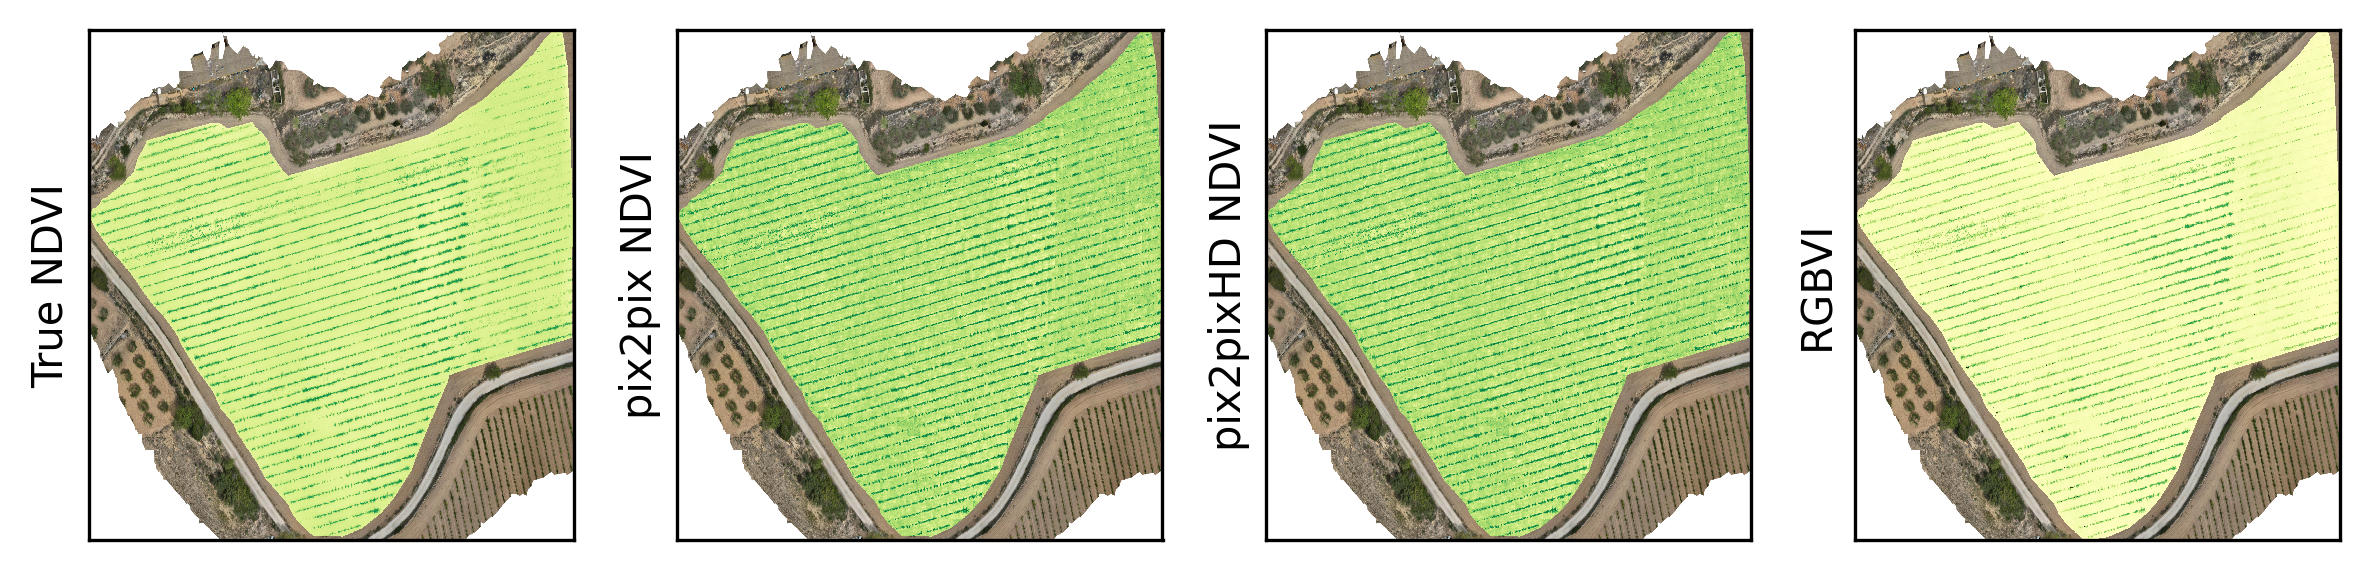

In [61]:

fig,ax = plt.subplots(figsize=(8,2),nrows =1, ncols = 4,dpi=300)

xmin, ymin, xmax, ymax = ndvi_test.rio.bounds()

rgb_down.plot.imshow(ax=ax[0], add_colorbar=False)
ndvi_test_down.plot(ax=ax[0],cmap = "RdYlGn", vmin =-1, vmax =1, add_colorbar=False)
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("True NDVI")
ax[0].set_xlim((xmin,xmax))
ax[0].set_ylim((ymin, ymax))

rgb_down.plot.imshow(ax=ax[1], add_colorbar=False)
ndvi_p2p_down.plot(ax=ax[1], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("pix2pix NDVI")
ax[2].set_xlim((xmin,xmax))
ax[2].set_ylim((ymin, ymax))

rgb_down.plot.imshow(ax=ax[2], add_colorbar=False)
ndvi_p2p_down.plot(ax=ax[2], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("pix2pixHD NDVI")
ax[2].set_xlim((xmin,xmax))
ax[2].set_ylim((ymin, ymax))

rgb_down.plot.imshow(ax=ax[3], add_colorbar=False)
rgbvi_down.plot(ax=ax[3], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[3].set_title("")
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_xlabel("")
ax[3].set_ylabel("RGBVI")
ax[3].set_xlim((xmin,xmax))
ax[3].set_ylim((ymin, ymax))


plt.tight_layout()
plt.savefig("figures/can2023_ndvi_rgbvi.png")
plt.show()

In [54]:
# FOR CORRELATION CHECKS:
#flatten the ndvi arrays
ndvi_p2phd_flat = ndvi_p2phd.values.flatten()
ndvi_p2p_flat = ndvi_p2p.values.flatten()
ndvi_test_flat = ndvi_test.values.flatten()
rgbvi_flat=rgbvi.values.flatten()

In [9]:
print(len(ndvi_p2phd_flat),len( ndvi_test_flat))

267869961 267869961


In [55]:
df_p2p = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2p":ndvi_p2p_flat})
df_p2p = df_p2p.dropna(axis=0)

df_p2phd = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2phd":ndvi_p2phd_flat})
df_p2phd = df_p2phd.dropna(axis=0)
df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2p":ndvi_p2p_flat,"ndvi_p2phd":ndvi_p2phd_flat, "rgbvi":rgbvi_flat})
df = df.dropna(axis=0)

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4921: RuntimeWarning: invalid value encountered in cast
  ix1 = np.round(ix).astype(int)
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4922: RuntimeWarning: invalid value encountered in cast
  iy1 = np.round(iy).astype(int)
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4923: RuntimeWarning: invalid value encountered in cast
  ix2 = np.floor(ix).astype(int)
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4924: RuntimeWarning: invalid value encountered in cast
  iy2 = np.floor(iy).astype(int)
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4921: RuntimeWarning: invalid value encountered in cast
  ix1 = np.round(ix).astype(int)
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4922: RuntimeWarning: invalid value encountered in cast
  iy1 = np.round(iy).asty

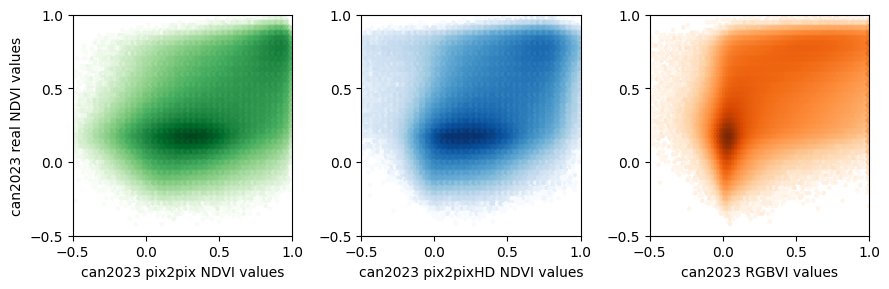

In [56]:
fig, ax = plt.subplots(figsize=(9,3), ncols =3)

#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[0],x = "ndvi_p2p", y = "ndvi_true",extent = (-1,1,-1,1), gridsize=100,cmap = 'Greens', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[0].set_xlim(-0.5,1)
ax[0].set_ylim(-0.5,1)
ax[0].set_xticks([-0.5, 0, 0.5, 1])
ax[0].set_yticks([-0.5, 0, 0.5, 1])
ax[0].set_xlabel('can2023 pix2pix NDVI values')
ax[0].set_ylabel('can2023 real NDVI values')

#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[1],x = "ndvi_p2phd", y = "ndvi_true",extent = (-1,1,-1,1), gridsize=100,cmap = 'Blues', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[1].set_xlim(-0.5,1)
ax[1].set_ylim(-0.5,1)
ax[1].set_xticks([-0.5, 0, 0.5, 1])
ax[1].set_yticks([-0.5, 0, 0.5, 1])
ax[1].set_xlabel('can2023 pix2pixHD NDVI values')
ax[1].set_ylabel('')

df.plot.hexbin(ax=ax[2],x = "rgbvi", y = "ndvi_true",extent = (-1,1,-1,1), gridsize=100,cmap = 'Oranges', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[2].set_xlim(-0.5,1)
ax[2].set_ylim(-0.5,1)
ax[2].set_xticks([-0.5, 0, 0.5, 1])
ax[2].set_yticks([-0.5, 0, 0.5, 1])
ax[2].set_xlabel('can2023 RGBVI values')
ax[2].set_ylabel('')

plt.tight_layout()
plt.savefig("figures/can_hexbin_true_vs_p2p_p2phd_rgbvi.png", dpi =300)
plt.show()

In [57]:
from sklearn.metrics import r2_score, mean_squared_error

df = df_p2p
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
df = df.loc[(df["ndvi_p2p"]>-1) & (df["ndvi_p2p"]<1)]
df = df.loc[(df["ndvi_true"]>-1) & (df["ndvi_true"]<1)]

x= df["ndvi_p2p"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)


print("R-squared:", "{:.2f}".format(r2))
print("Mean Squared Error:", "{:.2f}".format(mse))
print("Root Mean Squared Error:", "{:.2f}".format(rmse))

R-squared: 0.04
Mean Squared Error: 0.04
Root Mean Squared Error: 0.20


In [58]:
from sklearn.metrics import r2_score, mean_squared_error
df = df_p2phd
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
df = df.loc[(df["ndvi_p2phd"]>-1) & (df["ndvi_p2phd"]<1)]
df = df.loc[(df["ndvi_true"]>-1) & (df["ndvi_true"]<1)]

x= df["ndvi_p2phd"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)

print("R-squared:", "{:.2f}".format(r2))
print("Mean Squared Error:", "{:.2f}".format(mse))
print("Root Mean Squared Error:", "{:.2f}".format(rmse))

R-squared: 0.28
Mean Squared Error: 0.02
Root Mean Squared Error: 0.15


In [59]:
from sklearn.metrics import r2_score, mean_squared_error
df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "rgbvi":rgbvi_flat})
df = df.dropna(axis=0)
df = df.loc[(df["rgbvi"]>-1) & (df["rgbvi"]<1)].reset_index()
df = df.loc[(df["ndvi_true"]>-1) & (df["ndvi_true"]<1)].reset_index()


x= df["rgbvi"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)
print("R-squared:", "{:.2f}".format(r2))
print("Mean Squared Error:", "{:.2f}".format(mse))
print("Root Mean Squared Error:", "{:.2f}".format(rmse))

R-squared: -0.45
Mean Squared Error: 0.03
Root Mean Squared Error: 0.18


# BTG2021-test pixel-level evaluation

In [ ]:
#and the mask
roi = gpd.read_file("../data/bbr/btg2021_test/roi.geojson")

rgbvi = rgbvi.rio.clip(roi.geometry)
rgbvi.rio.to_raster("../data/orthos/preprocessed/btg_2021_test/rgbvi2.tif")

In [4]:
# load data btg2021

ndvi_p2phd = rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/ndvi_p2phd.tif",mode = "w")
ndvi_p2p = rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/ndvi_p2p.tif",mode = "w")
ndvi_test = rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/ndvi_test.tif",mode = "w")
rgbvi = rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/rgbvi.tif",mode = "w")

rgb = rxr.open_rasterio("../data/orthos/rgb_2021.tif", mode ="w")

In [5]:
from rasterio.enums import Resampling

upscale_factor =0.1
new_width = ndvi_test.rio.width * upscale_factor
new_height = ndvi_test.rio.height * upscale_factor

rgb_down = rgb.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)

ndvi_test_down =ndvi_test.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
)
ndvi_p2p_down =ndvi_p2p.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
)
ndvi_p2phd_down =ndvi_p2phd.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
)
rgbvi_down = rgbvi.rio.reproject(
    ndvi_test.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear,
    nodata=np.nan
    
)

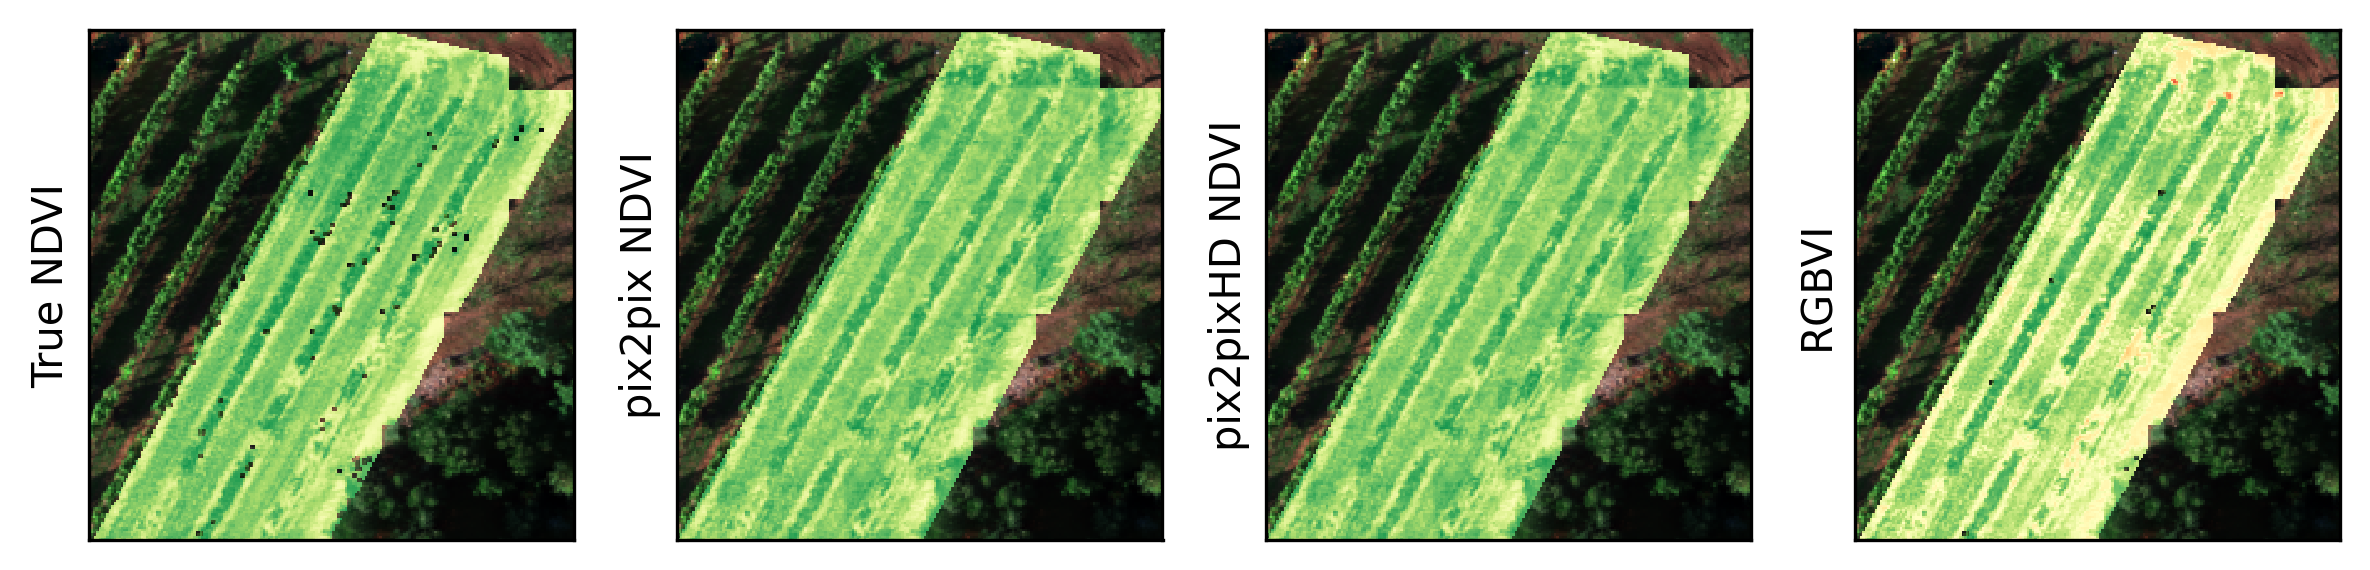

In [6]:

fig,ax = plt.subplots(figsize=(8,2),nrows =1, ncols = 4,dpi=300)

xmin, ymin, xmax, ymax = ndvi_test.rio.bounds()

rgb_down.plot.imshow(ax=ax[0], add_colorbar=False)
ndvi_test_down.plot(ax=ax[0],cmap = "RdYlGn", vmin =-1, vmax =1, add_colorbar=False)
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("True NDVI")
ax[0].set_xlim((xmin,xmax))
ax[0].set_ylim((ymin, ymax))

rgb_down.plot.imshow(ax=ax[1], add_colorbar=False)
ndvi_p2p_down.plot(ax=ax[1], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("pix2pix NDVI")
ax[2].set_xlim((xmin,xmax))
ax[2].set_ylim((ymin, ymax))

rgb_down.plot.imshow(ax=ax[2], add_colorbar=False)
ndvi_p2p_down.plot(ax=ax[2], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("pix2pixHD NDVI")
ax[2].set_xlim((xmin,xmax))
ax[2].set_ylim((ymin, ymax))

rgb_down.plot.imshow(ax=ax[3], add_colorbar=False)
rgbvi_down.plot(ax=ax[3], cmap ="RdYlGn",vmin=-1, vmax=1,add_colorbar=False)
ax[3].set_title("")
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_xlabel("")
ax[3].set_ylabel("RGBVI")
ax[3].set_xlim((xmin,xmax))
ax[3].set_ylim((ymin, ymax))


plt.tight_layout()
plt.savefig("figures/btg2021_ndvi_rgbvi.png")
plt.show()

In [7]:
# FOR CORRELATION CHECKS:
#flatten the ndvi arrays
ndvi_p2phd_flat = ndvi_p2phd.values.flatten()
ndvi_p2p_flat = ndvi_p2p.values.flatten()
ndvi_test_flat = ndvi_test.values.flatten()
rgbvi_flat=rgbvi.values.flatten()

In [8]:
df_p2p = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2p":ndvi_p2p_flat})
df_p2p = df_p2p.dropna(axis=0)

df_p2phd = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2phd":ndvi_p2phd_flat})
df_p2phd = df_p2phd.dropna(axis=0)
df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "ndvi_p2p":ndvi_p2p_flat,"ndvi_p2phd":ndvi_p2phd_flat, "rgbvi":rgbvi_flat})
df = df.dropna(axis=0)

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4921: RuntimeWarning: invalid value encountered in cast
  ix1 = np.round(ix).astype(int)
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\matplotlib\axes\_axes.py:4923: RuntimeWarning: invalid value encountered in cast
  ix2 = np.floor(ix).astype(int)


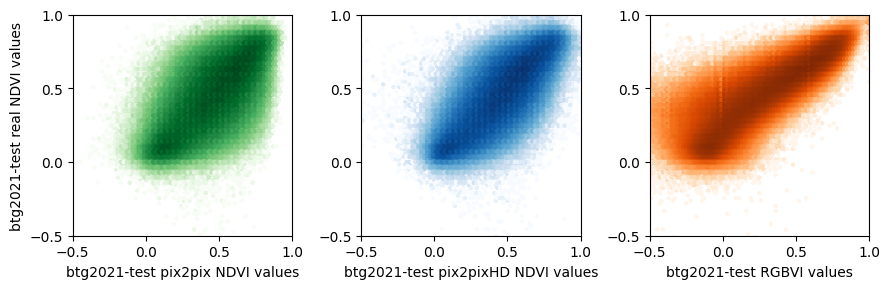

In [9]:
fig, ax = plt.subplots(figsize=(9,3), ncols =3)

#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[0],x = "ndvi_p2p", y = "ndvi_true",extent = (-1,1,-1,1), gridsize=100,cmap = 'Greens', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[0].set_xlim(-0.5,1)
ax[0].set_ylim(-0.5,1)
ax[0].set_xticks([-0.5, 0, 0.5, 1])
ax[0].set_yticks([-0.5, 0, 0.5, 1])
ax[0].set_xlabel('btg2021-test pix2pix NDVI values')
ax[0].set_ylabel('btg2021-test real NDVI values')

#ax.scatter(x, y, c=z, cmap='jet', marker='.')
df.plot.hexbin(ax=ax[1],x = "ndvi_p2phd", y = "ndvi_true",extent = (-1,1,-1,1), gridsize=100,cmap = 'Blues', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[1].set_xlim(-0.5,1)
ax[1].set_ylim(-0.5,1)
ax[1].set_xticks([-0.5, 0, 0.5, 1])
ax[1].set_yticks([-0.5, 0, 0.5, 1])
ax[1].set_xlabel('btg2021-test pix2pixHD NDVI values')
ax[1].set_ylabel('')

df.plot.hexbin(ax=ax[2],x = "rgbvi", y = "ndvi_true",extent = (-1,1,-1,1), gridsize=100,cmap = 'Oranges', bins= "log", colorbar= False)
# Plot the perfect line passing through (-1, -1) and (1, 1)

ax[2].set_xlim(-0.5,1)
ax[2].set_ylim(-0.5,1)
ax[2].set_xticks([-0.5, 0, 0.5, 1])
ax[2].set_yticks([-0.5, 0, 0.5, 1])
ax[2].set_xlabel('btg2021-test RGBVI values')
ax[2].set_ylabel('')

plt.tight_layout()
plt.savefig("figures/btg2021_hexbin_true_vs_p2p_p2phd_rgbvi.png", dpi =300)
plt.show()

In [55]:
from sklearn.metrics import r2_score, mean_squared_error

df = df_p2p
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
df = df.loc[(df["ndvi_p2p"]>-1) & (df["ndvi_p2p"]<1)]
df = df.loc[(df["ndvi_true"]>-1) & (df["ndvi_true"]<1)]

x= df["ndvi_p2p"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)


print("R-squared:", "{:.3f}".format(r2))
print("Mean Squared Error:", "{:.3f}".format(mse))
print("Root Mean Squared Error:", "{:.3f}".format(rmse))

R-squared: 0.407
Mean Squared Error: 0.024
Root Mean Squared Error: 0.153


In [56]:
from sklearn.metrics import r2_score, mean_squared_error
df = df_p2phd
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
df = df.loc[(df["ndvi_p2phd"]>-1) & (df["ndvi_p2phd"]<1)]
df = df.loc[(df["ndvi_true"]>-1) & (df["ndvi_true"]<1)]

x= df["ndvi_p2phd"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)

print("R-squared:", "{:.3f}".format(r2))
print("Mean Squared Error:", "{:.3f}".format(mse))
print("Root Mean Squared Error:", "{:.3f}".format(rmse))

R-squared: 0.554
Mean Squared Error: 0.018
Root Mean Squared Error: 0.136


In [12]:
from sklearn.metrics import r2_score, mean_squared_error
df = pd.DataFrame({"ndvi_true":ndvi_test_flat, "rgbvi":rgbvi_flat})
df = df.dropna(axis=0)
df = df.loc[(df["rgbvi"]>-1) & (df["rgbvi"]<1)].reset_index()
df = df.loc[(df["ndvi_true"]>-1) & (df["ndvi_true"]<1)].reset_index()


x= df["rgbvi"].tolist()
y =df["ndvi_true"].tolist()

r2 = r2_score(x, y)
mse = mean_squared_error(x,y)
rmse = np.sqrt(mse)
print("R-squared:", "{:.2f}".format(r2))
print("Mean Squared Error:", "{:.2f}".format(mse))
print("Root Mean Squared Error:", "{:.2f}".format(rmse))

R-squared: 0.35
Mean Squared Error: 0.06
Root Mean Squared Error: 0.24


# 3. SSIM values BTG + CAN

In [16]:
# SSIM
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [17]:
import re

def check_pattern_matches(pattern, string_list):
    matched_strings = []
    for string in string_list:
        if re.search(pattern, string):
            matched_strings.append(string)
    return matched_strings
# load them as images

import numpy as np
from PIL import Image

def image_to_numpy_array(image_path):
    # Open the image using Pillow
    image = Image.open(image_path)

    # Convert the image to a NumPy array
    numpy_array = np.array(image)

    return numpy_array

## BODEGAS TERRAS GAUDAS 2022 ssim

In [13]:
#Reconstruct an epoch that has passed thorugh p2p
folder = "../data/generated_ndvi/trgb_ndvi_v2_256"

fakeb = "fake_B"
realb = "real_B"
reala = "real_A"

        
imgs = [os.path.join(img) for img in os.listdir(folder)]

real_ndvi_btg_p2p = [os.path.join(folder, file) for file in check_pattern_matches(realb, imgs)]
fake_ndvi_btg_p2p = [os.path.join(folder, file) for file in check_pattern_matches(fakeb, imgs)]

In [14]:
rgbvi_btg = [os.path.join("../data/rgbvi_btg_2022_chips_256", file) for file in check_pattern_matches(".jpg", os.listdir("../data/rgbvi_btg_2022_chips_256"))]

In [15]:
rgbvi_btg = [image_to_numpy_array(file) for file in rgbvi_btg]
real_ndvi_btg_p2p = [image_to_numpy_array(file)[:,:,0] for file in real_ndvi_btg_p2p]
fake_ndvi_btg_p2p = [image_to_numpy_array(file)[:,:,0] for file in fake_ndvi_btg_p2p]

In [16]:
ssims = [ssim(fake, real, gaussian_weights=True) for fake, real in zip(fake_ndvi_btg_p2p, real_ndvi_btg_p2p)]
print("btg2022 p2p SSIM: ", sum(ssims)/len(ssims))

btg2022 p2p SSIM:  0.27451909683447345


In [17]:
psnirs = [psnr(fake, real) for fake, real in zip(fake_ndvi_btg_p2p, real_ndvi_btg_p2p)]
print("btg2022 p2p PSNR: ", sum(psnirs)/len(psnirs))

btg2022 p2p PSNR:  11.223051906696998


In [19]:
ssims = [ssim(fake, real, gaussian_weights=True) for fake, real in zip(rgbvi_btg, real_ndvi_btg_p2p)]
print("btg2022 rgbvi SSIM: ", sum(ssims)/len(ssims))

btg2022 rgbvi SSIM:  0.44739316790350697


In [20]:
psnirs = [psnr(fake, real) for fake, real in zip(rgbvi_btg, real_ndvi_btg_p2p)]
print("btg2022 rgbvi PSNR: ", sum(psnirs)/len(psnirs))

btg2022 rgbvi PSNR:  9.408076515780719


In [91]:
#Reconstruct an epoch that has passed thorugh p2p
folder = "../data/generated_ndvi/trgb_ndvi_512"

fakeb = "synthesized_image"
realb = "input_label"
reala = "input_label"
        
imgs = [os.path.join(img) for img in os.listdir(folder)]
fake_ndvi_btg_p2phd = [os.path.join(folder, file) for file in check_pattern_matches(fakeb, imgs)]

hd_truth_folder = "../data/p2pHD_msrgb_512/B/test2022"
real_ndvi_btg_p2phd  =[os.path.join(hd_truth_folder, img) for img in os.listdir(hd_truth_folder)]


In [92]:

real_ndvi_btg_p2phd = [image_to_numpy_array(file) for file in real_ndvi_btg_p2phd]
fake_ndvi_btg_p2phd = [image_to_numpy_array(file) for file in fake_ndvi_btg_p2phd]

In [93]:
ssims = [ssim(fake, real, gaussian_weights=True) for fake, real in zip(fake_ndvi_btg_p2phd, real_ndvi_btg_p2phd)]
print("btg2022 p2phd SSIM: ", sum(ssims)/len(ssims))

btg2022 p2phd SSIM:  0.3035963528913608


In [126]:
psnirs = [psnr(fake, real) for fake, real in zip(fake_ndvi_btg_p2phd, real_ndvi_btg_p2phd)]
print("btg2022 p2p PSNR: ", sum(psnirs)/len(psnirs))

btg2022 p2p PSNR:  16.948708091526182


## CANYELLES 2023 ssim

In [21]:
#Reconstruct an epoch that has passed thorugh p2p
folder = "../data/generated_ndvi/canyelles_trgb_ndvi_256"

fakeb = "fake_B"
realb = "real_B"
reala = "real_A"

        
imgs = [os.path.join(img) for img in os.listdir(folder)]

real_ndvi_can_p2p = [os.path.join(folder, file) for file in check_pattern_matches(realb, imgs)]
fake_ndvi_can_p2p = [os.path.join(folder, file) for file in check_pattern_matches(fakeb, imgs)]

In [23]:
rgbvi_btg = [os.path.join("../data/rgbvi_canyelles_2023_chips_256", file) for file in check_pattern_matches(".jpg", os.listdir("../data/rgbvi_canyelles_2023_chips_256"))]

In [24]:
rgbvi_btg = [image_to_numpy_array(file) for file in rgbvi_btg]
real_ndvi_can_p2p = [image_to_numpy_array(file)[:,:,0] for file in real_ndvi_can_p2p]
fake_ndvi_can_p2p = [image_to_numpy_array(file)[:,:,0] for file in fake_ndvi_can_p2p]

In [25]:
ssims = [ssim(fake, real, gaussian_weights=True) for fake, real in zip(fake_ndvi_can_p2p, real_ndvi_can_p2p)]
print("can2023 p2p SSIM: ", sum(ssims)/len(ssims))

can2023 p2p SSIM:  0.31180045051225874


In [26]:
psnirs = [psnr(fake, real) for fake, real in zip(fake_ndvi_can_p2p, real_ndvi_can_p2p)]
print("can2023 p2p PSNR: ", sum(psnirs)/len(psnirs))

can2023 p2p PSNR:  19.234844569501245


In [27]:
ssims = [ssim(fake, real, gaussian_weights=True) for fake, real in zip(rgbvi_btg, real_ndvi_btg_p2p)]
print("can2023 rgbvi SSIM: ", sum(ssims)/len(ssims))

can2023 rgbvi SSIM:  0.6221441708742246


In [28]:
psnirs = [psnr(fake, real) for fake, real in zip(rgbvi_btg, real_ndvi_btg_p2p)]
print("can2023 rgbvi PSNR: ", sum(psnirs)/len(psnirs))

can2023 rgbvi PSNR:  7.470317841586354


In [97]:
#Reconstruct an epoch that has passed thorugh p2p
folder = "../data/generated_ndvi/canyelles_trgb_ndvi_512"

fakeb = "synthesized_image"
realb = "input_label"
reala = "input_label"
        
imgs = [os.path.join(img) for img in os.listdir(folder)]

fake_ndvi_can_p2phd = [os.path.join(folder, file) for file in check_pattern_matches(fakeb, imgs)]


hd_truth_folder = "../data/ndvi_canyelles_2022_chips_512"
real_ndvi_can_p2phd  =[os.path.join(hd_truth_folder, img) for img in os.listdir(hd_truth_folder)]


In [98]:

real_ndvi_can_p2phd = [image_to_numpy_array(file) for file in real_ndvi_can_p2phd]
fake_ndvi_can_p2phd = [image_to_numpy_array(file) for file in fake_ndvi_can_p2phd]

In [99]:
ssims = [ssim(fake, real, gaussian_weights=True) for fake, real in zip(fake_ndvi_can_p2phd, real_ndvi_can_p2phd)]
print("can2023 p2phd SSIM: ", sum(ssims)/len(ssims))

can2023 p2phd SSIM:  0.3898644972278145


In [128]:
psnirs = [psnr(fake, real) for fake, real in zip(fake_ndvi_can_p2phd, real_ndvi_can_p2phd)]
print("can2023 p2p PSNR: ", sum(psnirs)/len(psnirs))

btg2022 p2p PSNR:  21.76865320752265


# BTG2021-test SSIM/PSNR

In [41]:
#Reconstruct an epoch that has passed thorugh p2p
folder = "../data/generated_ndvi/msrgb_ndvi"

fakeb = "fake_B"
realb = "real_B"
reala = "real_A"

        
imgs = [os.path.join(img) for img in os.listdir(folder)]

real_ndvi_can_p2p = [os.path.join(folder, file) for file in check_pattern_matches(realb, imgs)]
fake_ndvi_can_p2p = [os.path.join(folder, file) for file in check_pattern_matches(fakeb, imgs)]

In [42]:
rgbvi_btg = [os.path.join("../data/rgbvi_btg_2021_chips_256", file) for file in check_pattern_matches(".jpg", os.listdir("../data/rgbvi_btg_2021_chips_256"))]

In [43]:
rgbvi_btg = [image_to_numpy_array(file) for file in rgbvi_btg]
real_ndvi_can_p2p = [image_to_numpy_array(file)[:,:,0] for file in real_ndvi_can_p2p]
fake_ndvi_can_p2p = [image_to_numpy_array(file)[:,:,0] for file in fake_ndvi_can_p2p]

In [44]:
ssims = [ssim(fake, real, gaussian_weights=True) for fake, real in zip(fake_ndvi_can_p2p, real_ndvi_can_p2p)]
print("btg2021 p2p SSIM: ", sum(ssims)/len(ssims))

btg2021 p2p SSIM:  0.4073948817598756


In [45]:
psnirs = [psnr(fake, real) for fake, real in zip(fake_ndvi_can_p2p, real_ndvi_can_p2p)]
print("btg2021 p2p PSNR: ", sum(psnirs)/len(psnirs))

btg2021 p2p PSNR:  22.485413648578056


In [46]:
ssims = [ssim(fake, real, gaussian_weights=True) for fake, real in zip(rgbvi_btg, real_ndvi_can_p2p)]
print("btg2021 rgbvi SSIM: ", sum(ssims)/len(ssims))

btg2021 rgbvi SSIM:  0.5768711401760358


In [48]:
psnirs = [psnr(fake, real) for fake, real in zip(rgbvi_btg, real_ndvi_can_p2p)]
print("btg2021 rgbvi PSNR: ", sum(psnirs)/len(psnirs))

btg2021 rgbvi PSNR:  18.472143917228877


In [49]:
#Reconstruct an epoch that has passed thorugh p2p
folder = "../data/generated_ndvi/msrgb_ndvi_512"

fakeb = "synthesized_image"
realb = "input_label"
reala = "input_label"
        
imgs = [os.path.join(img) for img in os.listdir(folder)]

fake_ndvi_can_p2phd = [os.path.join(folder, file) for file in check_pattern_matches(fakeb, imgs)]


hd_truth_folder = "../data/ndvi_canyelles_2022_chips_512"
real_ndvi_can_p2phd  =[os.path.join(hd_truth_folder, img) for img in os.listdir(hd_truth_folder)]


In [50]:

real_ndvi_can_p2phd = [image_to_numpy_array(file) for file in real_ndvi_can_p2phd]
fake_ndvi_can_p2phd = [image_to_numpy_array(file) for file in fake_ndvi_can_p2phd]

In [53]:
ssims = [ssim(fake, real, gaussian_weights=True) for fake, real in zip(fake_ndvi_can_p2phd, real_ndvi_can_p2phd)]
print("btg2021 p2phd SSIM: ", sum(ssims)/len(ssims))

btg2021 p2phd SSIM:  0.29806754541515534


In [54]:
psnirs = [psnr(fake, real) for fake, real in zip(fake_ndvi_can_p2phd, real_ndvi_can_p2phd)]
print("btg2021 p2p PSNR: ", sum(psnirs)/len(psnirs))

btg2021 p2p PSNR:  13.790542059840444
